In [1]:
import networkx as nx
import json

import umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec
from gensim.models.word2vec import Word2Vec

In [2]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Classifying of  Blogs in Social Media using Graph Machine Learning

## Introduction

We sort of averaged the label information from the node neighbours which is quite a naive approach (but effective). There is another way to extract the structural information from the graph - node embedding. If you've ever worked with NLP, you'll know what I'm talking about. We want to represent the nodes in the n-dimensional vector form that reflects the structural properties of the graph.

In [3]:
G = nx.karate_club_graph() 

clubs = []  
for n in G.nodes:
    c = G.nodes[n]['club']  
    clubs.append(1 if c == 'Officer' else 0)

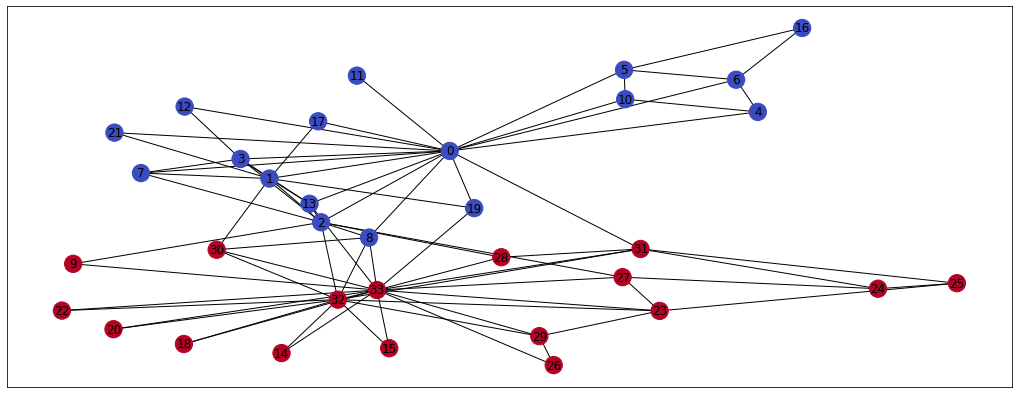

In [4]:
pos = nx.spring_layout(G, seed=42) 
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') 

Members of the karate clubs talk mainly to their club members. 

In [5]:
model = DeepWalk(dimensions=124) 
model.fit(G)  
embedding = model.get_embedding()  

print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


DeepWalk is now represented by a vector of size 124. These vectors should reflect the graph structure, i.e. the different clubs should be far away from each other. We can check it by reducing the 124 dimensional data into 2 dimensional data using `umap-learn` package and making a scatter plot.

/Users/antonsruberts/miniconda/envs/ravelin36/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


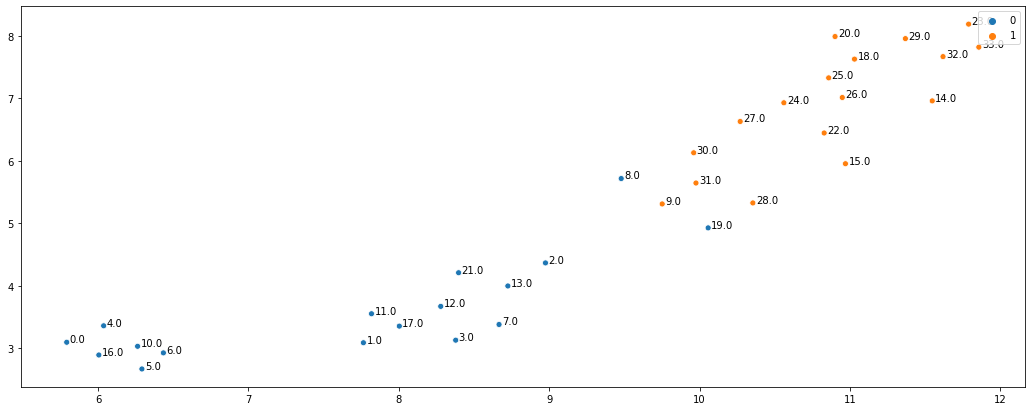

In [6]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(embedding)

ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = clubs)
a = pd.DataFrame({'x': umap_embs[:, 0], 'y': umap_embs[:, 1], 'val': G.nodes})
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['val']))

The embeddings did very well at representing the structure of the graph. Not only the two karate clubs are clearly separated but the members which are connected to the other clubs (e.g. nodes 28, 30, 8, and 2) are sort of more in the middle. In addition, the algorithm seems to have found a sub-community in the "Officer" karate club, which just shows how useful these embeddings can be. To summarise, DeepWalk (and any other node embedding algorithm) tries to represent the nodes as vectors which capture some structural information from the graph.



### Random Walk
Random walk is a sequence of nodes, where next node is chosen randomly from the adjacent nodes. 

In [7]:
def random_walk(start_node, walk_length):
    walk = [start_node]  
    
    for i in range(walk_length):
        all_neighbours = [n for n in G.neighbors(start_node)]  
        next_node = np.random.choice(all_neighbours, 1)[0]  
        walk.append(next_node) 
        start_node = next_node  
    
    return walk

Steps in random walk: [6, 5, 16, 5, 10, 5, 16, 5, 0, 7, 1, 3, 2, 27, 2, 7, 3, 2, 9, 2, 1]


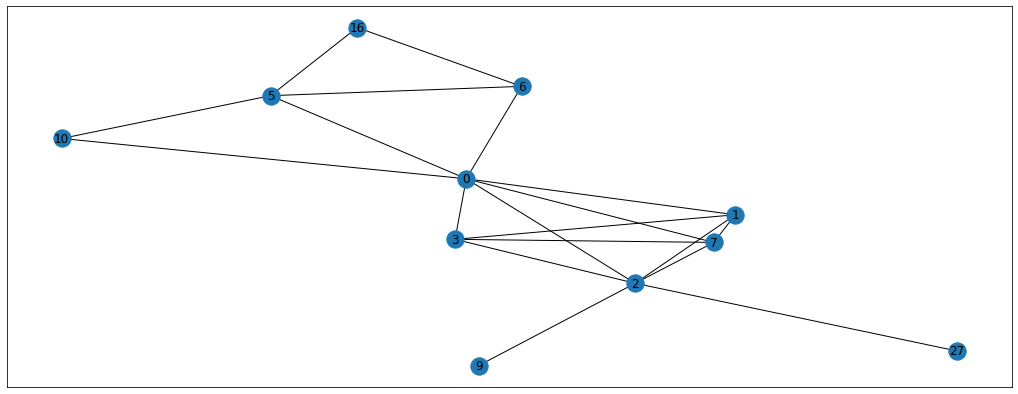

In [8]:
walk = random_walk(6, 20)  
print('Steps in random walk:', walk)

walk_graph = G.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap='coolwarm')

So we've generated a random walk with length of 20 starting at node 6. By repeating this random walk multiple times for all the nodes in the graph, we can get a bunch of "walk" sequences that contain useful information. The paper suggests doing around 32 walks per node with the walk length of 40. We could implement this with 2 for-loops but luckily for us, `karateclub` package has already implemented this for us (and it's much faster)

In [9]:
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(G) 

In [10]:
model = Word2Vec(walker.walks,  
                 hs=1, 
                 sg = 1, 
                 size=128, 
                 window=5,
                 min_count=1,
                 workers=4,
                 seed=42)
    

In [11]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (34, 128)


And that's it! The embeddings are trained, so you can use them e.g. as features for your supervised model or to find clusters in your dataset. Let's now see how we can use DeepWalk on real classification taks.

## Data Implementation

Data can be downloaded from github. There's 3 files - edges, targets, and features. 

In [12]:
edges_path = 'datasets-master/facebook_large/facebook_edges.csv'
targets_path = 'datasets-master/facebook_large/facebook_target.csv'
features_path = 'datasets-master/facebook_large/facebook_features.json'

In [13]:
edges = pd.read_csv(edges_path)
display(edges.head())

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [14]:
targets = pd.read_csv(targets_path)
targets.index = targets.id
targets.head()

,id,facebook_id,page_name,page_type
id,,,,
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [15]:
# Reading the json as a dict
with open(features_path) as json_data:
    features = json.load(json_data)

In [16]:
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|██████████| 22470/22470 [00:00<00:00, 61404.85it/s]


With data read in, we can build a graph now and generate the embeddings

### DeepWalk on the dataset

In [17]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")

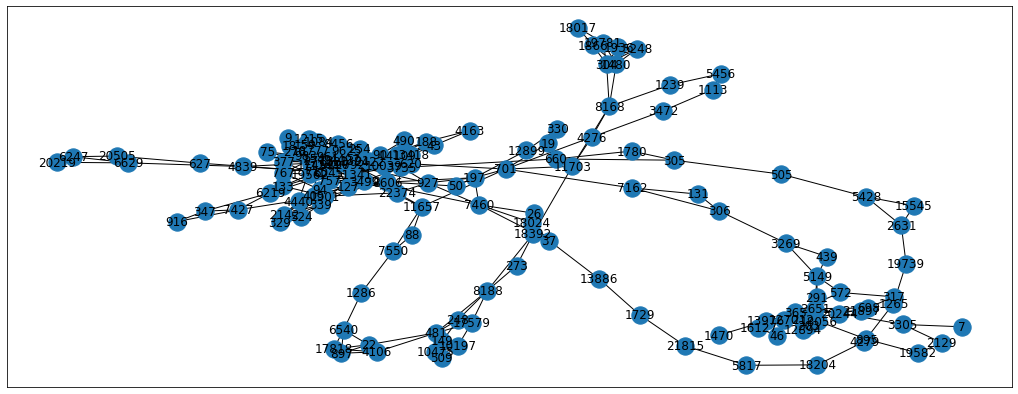

In [18]:
# Visualise some subgraph of 150 nodes
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))[:150] #Gets all the nodes in the graph that node 7 belongs to. 
G = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

In [19]:
# Do random walks
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(graph)

In [20]:
model = Word2Vec(walker.walks,  
                 hs=1, 
                 sg = 1,  
                 size=128, 
                 window=10,
                 min_count=1,
                 iter = 1,
                 workers=4,
                 seed=42)

Model is now trained, so we can use the embeddings for classification. We can do a quick sense check of the model by looking at the nearest neighbours in the embeddings space of some of the facebook blogs. 

In [21]:
similar_to = '22196'
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
22196,22196,205251616243022,American Express,company
19398,19398,143171822476722,American Express,company
351,351,411991108813820,American Express,company
16984,16984,117495044948602,American Express אמריקן אקספרס,company
20075,20075,366195136783660,American Express,company


In [22]:
similar_to = '451'
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
451,451,104667776288021,BBC Apprentice,tvshow
21470,21470,26363622695,The One Show,tvshow
452,452,169383494938,BBC EastEnders,tvshow
428,428,195063842004,BBC EastEnders: E20,tvshow
1429,1429,100865096953196,BBC Archive,tvshow


The nearest neighbours are incredibly similar to the original blogs and all of this is achieved without even knowing what the original blogs are about! Hence, the embeddings that the DeepWalk has learned are meaningful and we can use them in the classifier.

In [23]:
y = targets.loc[[int(i) for i in list(features.keys())], 'page_type']

X_dw = []
for i in y.index:
    X_dw.append(model.wv.__getitem__(str(i)))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.9374721851357365
[[0.94724943 0.03617182 0.00301432 0.01356443]
 [0.01568335 0.9626587  0.0201643  0.00149365]
 [0.00423729 0.04576271 0.94830508 0.00169492]
 [0.11419753 0.00925926 0.0308642  0.84567901]]


As you can see, the performance is really good with F1 score of ~0.92 

### Node2Vec on Facebook Graph

Node2Vec is very similar to DeepWalk, but the random walks are generated a bit differently. Recall that in the pure random walk, neighbourhood nodes have an equal propability to be chosen as next step. Here instead, we have 2 hyperparameters to tune - `p` and `q`. `p` and `q` control how fast the walk explores and leaves the neighborhood of starting node u.

* p - high values means that we're less likely to return to the previous node
* q - high values approximate the Breadth-First-Search meaning that the neighbourhood around the node is explored. Low values give higher chance to go outside the neighbourhood and hence approxiamtes the Depth-First-Search 

Let's compare 2 extreme scenarios:
1. p = 10, q = 0.1 - here we expect the random walk to go outwards and explore the adjacent clusters as well 
2. p = 0.1, q = 10 - here we expect the random walk to stay very local and explore the neighbourhood around the starting node

In [117]:
def biased_walk(start_node, walk_length, p, q):
    walk = [start_node]
    previous_node = None
    previous_node_neighbors = []
    for _ in range(walk_length-1):
        current_node = walk[-1]  
        current_node_neighbors = np.array(list(graph.neighbors(current_node))) 
        probability = np.array([1/q] * len(current_node_neighbors), dtype=float) 
        probability[current_node_neighbors==previous_node] = 1/p 
        probability[(np.isin(current_node_neighbors, previous_node_neighbors))] = 1  
        norm_probability = probability/sum(probability) 
        selected = np.random.choice(current_node_neighbors, 1, p=norm_probability)[0]  
        walk.append(selected)  
        previous_node_neighbors = current_node_neighbors
        previous_node = current_node
    
    return walk

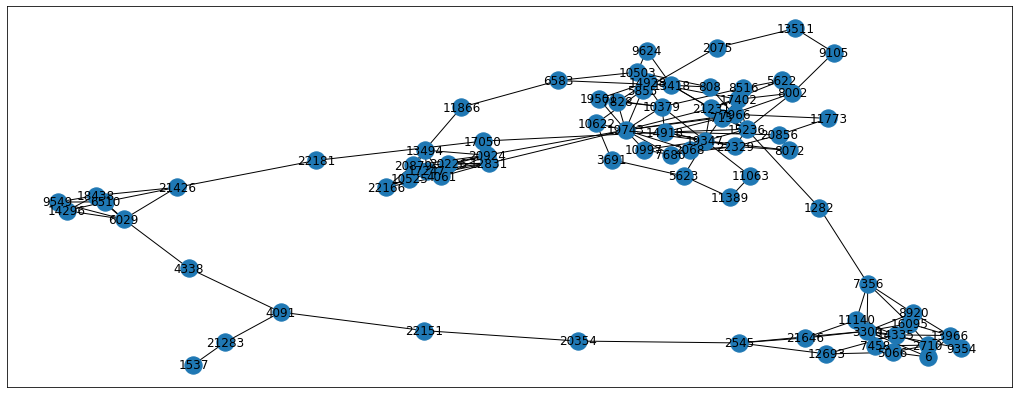

In [151]:
p = 10
q = 0.1
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

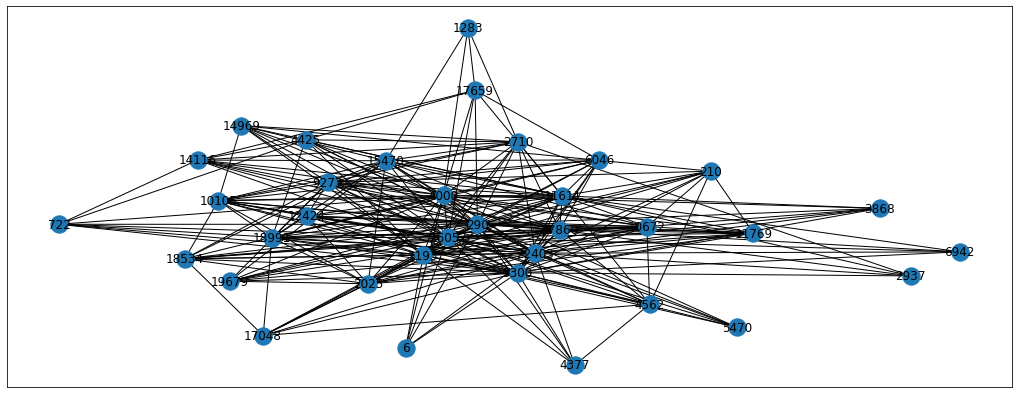

In [158]:
p = 0.1
q = 10
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7)) 
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')
    

In [159]:
b_walker = BiasedRandomWalker(80, 10, 0.5, 0.25)
b_walker.do_walks(graph)

In [160]:
node_vec = Word2Vec(b_walker.walks, 
                 hs=1,  
                 sg = 1,  
                 size=128,  
                 window=10,
                 min_count=1,
                 iter = 1,
                 workers=4,
                 seed=42)

In [162]:

X_node_vec = []
for i in y.index:
    X_node_vec.append(node_vec.wv.__getitem__(str(i)))

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, test_size=0.2) 

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.9296840231419671
[[9.43410853e-01 3.33333333e-02 3.10077519e-03 2.01550388e-02]
 [1.46950771e-02 9.54445261e-01 3.01249082e-02 7.34753857e-04]
 [5.18134715e-03 6.04490501e-02 9.31778929e-01 2.59067358e-03]
 [9.92700730e-02 2.04379562e-02 2.91970803e-02 8.51094891e-01]]


As can be seen from the embeddings, the `company`, `government`, and `tvshows` are represented by clear clusters whereas `politician` clusters is kind of scattered around. Plus, there are blogs which are not clustered meaning that they are probably much harder to classify. 